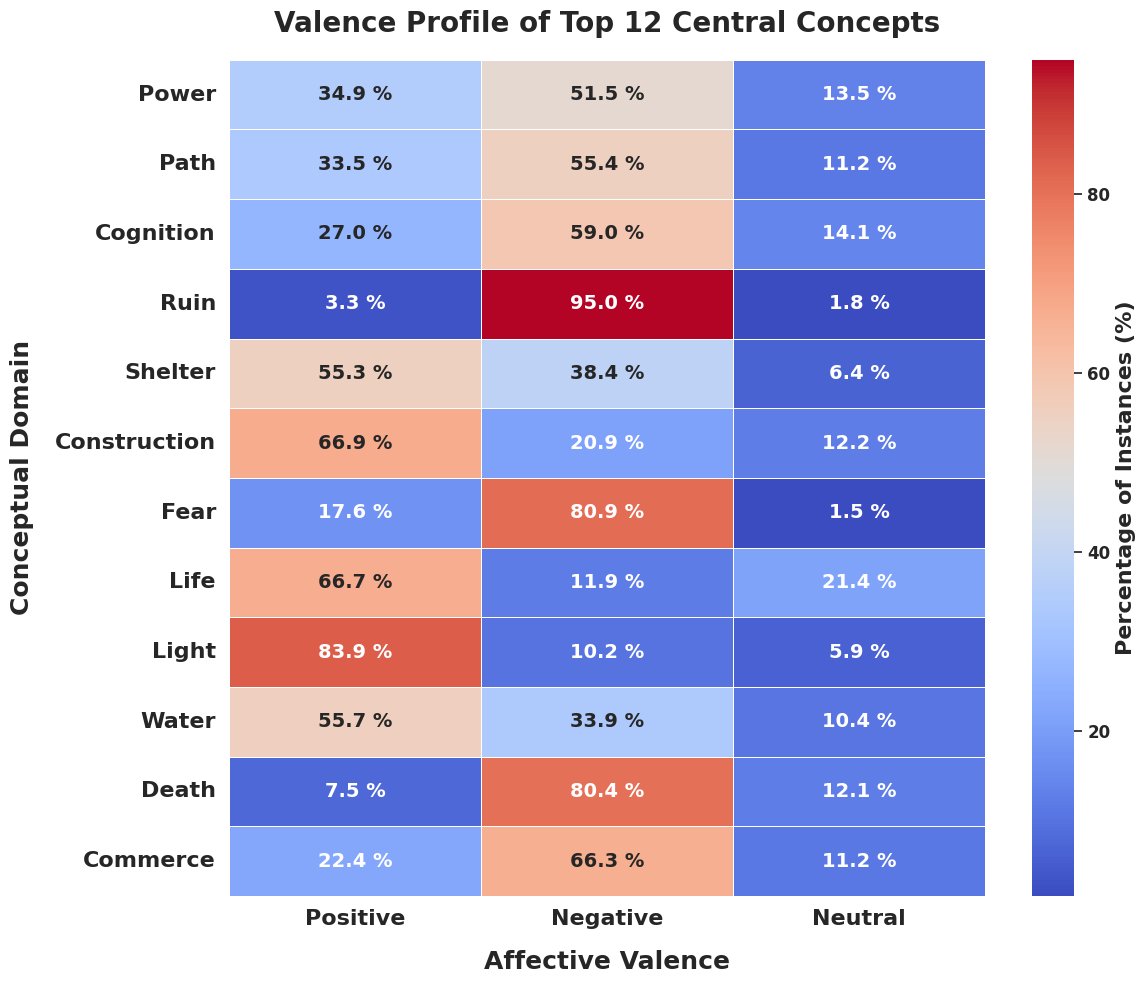

In [ ]:
#@title  **Valence Profile of Top 12 Central Concepts**


# --- [الخطوة 0: التثبيت والاستيراد] ---
!git clone https://github.com/NoorBayan/Amthal.git
%cd Amthal
from utility import *
from IPython.display import display, HTML, clear_output


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import io
from itertools import combinations



# --- [الخطوة 1: تحميل وتجهيز البيانات] ---
print("--- [Step 1: Loading Data] ---")
# ⚠️⚠️⚠️  الرجاء التأكد من أن هذا المسار صحيح في بيئتك
INSTANCES_FILE_PATH = '/content/Amthal/data/processed/instances.csv'
try:
    df = pd.read_csv(INSTANCES_FILE_PATH, sep='\t', encoding='utf-16')
    df['Dominant_Concept']=[Dominant_Concept_dic[i]['en'] for i in df.Dominant_Concept]
    df['Valence']=[Valence_dic[i]['ar'] for i in df.Valence]

    print(f"Data loaded successfully. Found {len(df)} instances.\n")
except FileNotFoundError:
    print(f"⚠️ ERROR: File not found at '{INSTANCES_FILE_PATH}'. Please check the path and try again.")
    exit()


# *** الخطوة الجديدة: ترجمة عمود Valence ***
valence_map = {
    'إيجابي': 'Positive',
    'سلبي': 'Negative',
    'محايد': 'Neutral'
}
df['Valence'] = df['Valence'].map(valence_map)

# --- 2. تحديد أهم المفاهيم من بياناتك الحقيقية ---
# سنختار أهم 12 مفهومًا بناءً على التكرار الفعلي في الكوربس
top_n_concepts = df['Dominant_Concept'].value_counts().nlargest(12).index

# فلترة الـ DataFrame ليحتوي فقط على بيانات هذه المفاهيم
df_top_concepts = df[df['Dominant_Concept'].isin(top_n_concepts)]


# --- 3. بناء وتطبيع جدول الطوارئ من بياناتك الحقيقية ---

# الخطوة أ: إنشاء جدول الطوارئ (العد الخام)
# crosstab سيقوم بالعد تلقائيًا من الـ df المفلتر
contingency_table = pd.crosstab(df_top_concepts['Dominant_Concept'], df_top_concepts['Valence'])

# الخطوة ب: التطبيع (Normalization) للحصول على نسب مئوية لكل صف (مفهوم)
# .div(contingency_table.sum(axis=1), axis=0) يقسم كل صف على مجموعه
normalized_table = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

# فرز الصفوف (المفاهيم) لتطابق ترتيب الأهمية (من الأكثر تكرارًا إلى الأقل)
# هذا يضمن أن المفاهيم الأعلى في الرسم البياني هي الأهم
normalized_table = normalized_table.loc[top_n_concepts]


# --- 4. إعداد الرسم البياني الاحترافي (Heatmap) ---
# (بقية الكود تبقى كما هي تمامًا لأنها تعمل على normalized_table)
sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(12, 10))

# تأكد من أن كل الأعمدة (إيجابي، سلبي، محايد) موجودة لتجنب الأخطاء
# إذا كانت فئة ما غير موجودة لمفهوم معين، crosstab سيملؤها بـ 0
#all_valences = ['إيجابي', 'سلبي', 'محايد']
all_valences = ['Positive', 'Negative', 'Neutral']

for v in all_valences:
    if v not in normalized_table.columns:
        normalized_table[v] = 0

heatmap = sns.heatmap(
    normalized_table[all_valences], # نستخدم القائمة لضمان ترتيب الأعمدة
    annot=True,
    fmt=".1f",
    linewidths=.5,
    cmap='coolwarm',
    cbar_kws={'label': 'Percentage of Instances (%)'},
    ax=ax
)


# --- 5. إضافة التحسينات البصرية ---
ax.set_title('Valence Profile of Top 12 Central Concepts', fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('Affective Valence', fontsize=18,fontweight='bold', labelpad=15)
ax.set_ylabel('Conceptual Domain', fontsize=18,fontweight='bold', labelpad=15)


ax.tick_params(axis='x', labelrotation=0, labelsize=16)
ax.tick_params(axis='y', labelrotation=0, labelsize=16)

# جعل أرقام المحاور عريضة
plt.setp(ax.get_xticklabels(), fontweight='bold')
plt.setp(ax.get_yticklabels(), fontweight='bold')

for t in heatmap.texts:
    t.set_text(t.get_text() + " %")
    t.set_fontsize(14)       # حجم الخط داخل الخلية
    t.set_fontweight('bold') # خط عريض

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.ax.yaxis.label.set_size(14)

# --- تكبير الخط وعريض للـ colorbar ---
cbar.set_label('Percentage of Instances (%)', fontsize=16, fontweight='bold')  # عنوان المفتاح
for tick in cbar.ax.get_yticklabels():
    tick.set_fontweight('bold')     # جعل الأرقام عريضة


# --- 6. الحفظ والعرض ---
plt.tight_layout()
plt.savefig('Valence_Heatmap.png', dpi=300, bbox_inches='tight')
clear_output()
plt.show()